In [31]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [32]:
path = 'data/crypto/BTCUSDT.csv'
df = pd.read_csv(path)
df

,timestamp_utc,timestamp,open,high,low,close,volume,turnover
0,2020-03-25 10:30:08.128000+00:00,1585132200000,6500.0,6500.0,6500.0,6500.0,0.002,1.300000e+01
1,2020-03-25 10:45:25.632000+00:00,1585133100000,6500.0,6591.5,6500.0,6591.5,0.002,1.318300e+01
2,2020-03-25 11:00:43.136000+00:00,1585134000000,6591.5,6622.5,6585.5,6590.5,37.803,2.491407e+05
3,2020-03-25 11:16:00.640000+00:00,1585134900000,6590.5,6628.5,6588.5,6618.0,141.338,9.353749e+05
4,2020-03-25 11:29:07.072000+00:00,1585135800000,6618.0,6618.0,6457.5,6499.5,120.703,7.845091e+05
...,...,...,...,...,...,...,...,...
132798,2024-01-07 17:59:02.400000+00:00,1704650400000,44070.9,44150.0,44037.9,44118.0,519.299,2.290517e+07
132799,2024-01-07 18:14:19.904000+00:00,1704651300000,44118.0,44173.3,44100.0,44113.8,326.239,1.439852e+07
132800,2024-01-07 18:29:37.408000+00:00,1704652200000,44113.8,44184.9,44108.8,44158.3,366.902,1.620259e+07
132801,2024-01-07 18:44:54.912000+00:00,1704653100000,44158.3,44189.9,44093.5,44106.5,602.564,2.659858e+07


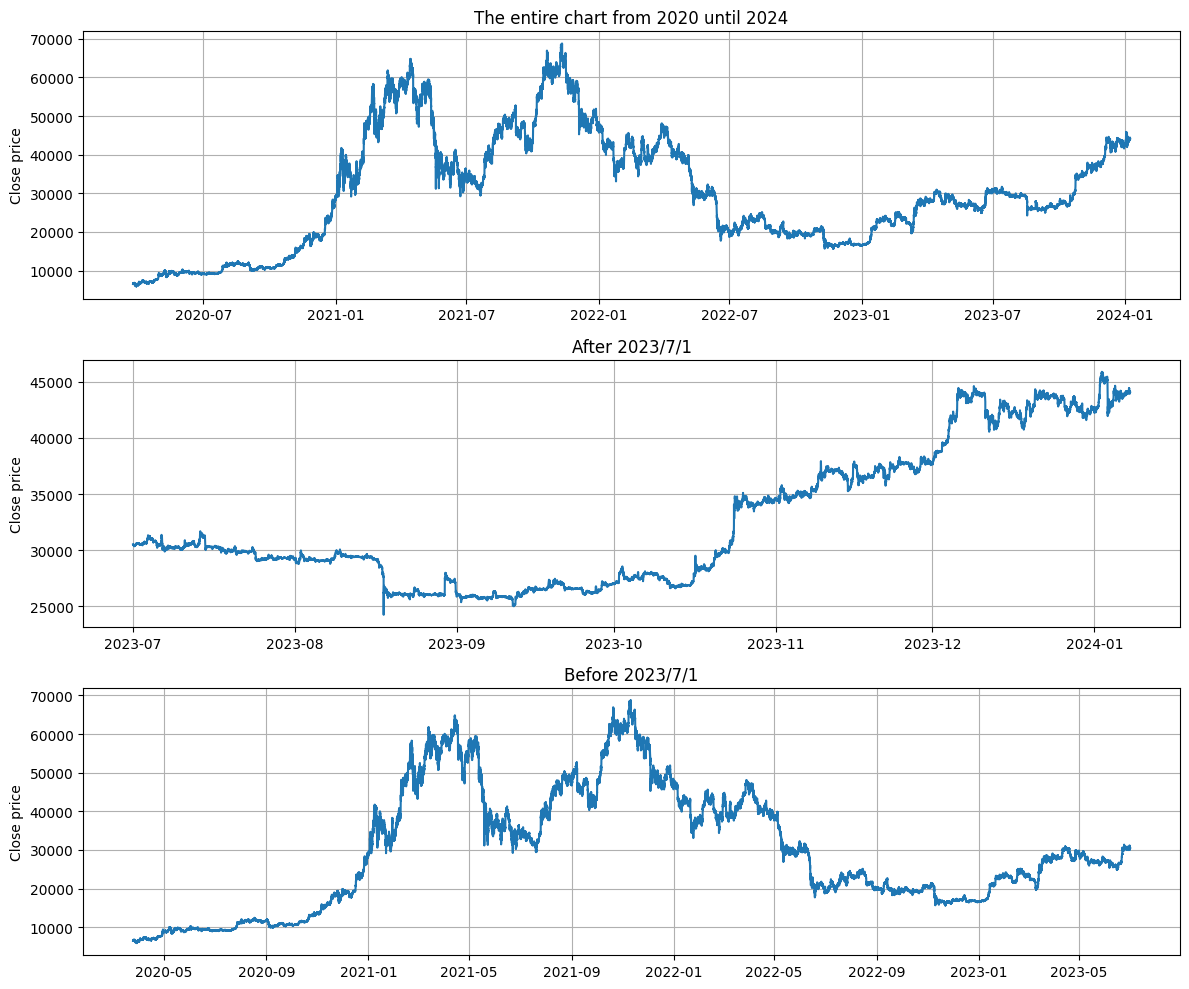

132803
18324
114478


In [33]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
axes = axes.flatten()

cut_date = int(dt.datetime(2023, 7, 1).timestamp() * 1000)

y = df['close']
x = [dt.datetime.fromtimestamp(timestamp) for timestamp in (df['timestamp'] / 1000)]

axes[0].plot(x, y)
axes[0].grid(True)
axes[0].set_ylabel('Close price')
axes[0].set_xlabel(None)
axes[0].set_title('The entire chart from 2020 until 2024')

after_cut_date = df[df['timestamp'] > cut_date]
before_cut_date = df[df['timestamp'] < cut_date]

y_after_cut_date = after_cut_date['close']
x_after_cut_date = [dt.datetime.fromtimestamp(timestamp) for timestamp in (after_cut_date['timestamp'] / 1000)]

axes[1].plot(x_after_cut_date, y_after_cut_date)
axes[1].grid(True)
axes[1].set_ylabel('Close price')
axes[1].set_xlabel(None)
axes[1].set_title('After 2023/7/1')

y_before_cut_date = before_cut_date['close']
x_before_cut_date = [dt.datetime.fromtimestamp(timestamp) for timestamp in (before_cut_date['timestamp'] / 1000)]

axes[2].plot(x_before_cut_date, y_before_cut_date)
axes[2].grid(True)
axes[2].set_ylabel('Close price')
axes[2].set_xlabel(None)
axes[2].set_title('Before 2023/7/1')

plt.tight_layout()
plt.show()

print(len(y))
print(len(y_after_cut_date))
print(len(y_before_cut_date))

In [34]:
# X_train = before_cut_date.drop(['close', 'timestamp_utc'], axis=1)
# X_test = after_cut_date.drop(['close', 'timestamp_utc'], axis=1)
# y_train = before_cut_date['close']
# y_test = after_cut_date['close']

label = df['close']
estimators = df.drop(['close', 'timestamp_utc'], axis=1)
    
X_test, X_train, y_test, y_train = train_test_split(estimators, label, train_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [35]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=1)

106243/106243 [==============================] - 594s 6ms/step - loss: 31311192.0000


In [39]:
predictions = model.predict(X_test)
mse = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_absolute_error(y_test, predictions))

print('MSE:', mse)
print('RMSE:', rmse)

830/830 [==============================] - 3s 4ms/step
MSE: 263.4891715654121
RMSE: 16.232349539281493


/var/folders/_c/npprpzfn2fsgjjxzkzbrynlm0000gn/T/ipykernel_8525/3544383035.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


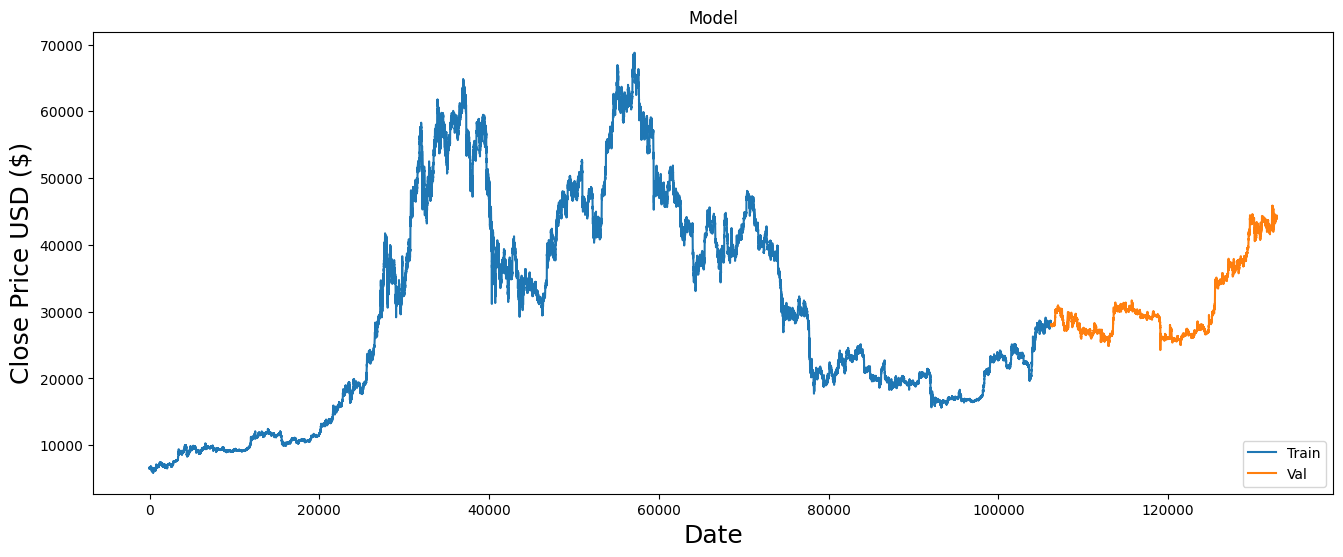

,timestamp_utc,timestamp,open,high,low,close,volume,turnover,Predictions
106243,2023-04-06 03:15:36.064000+00:00,1680750900000,28067.1,28088.9,28033.7,28065.7,531.618,1.491734e+07,26796.375000
106244,2023-04-06 03:30:53.568000+00:00,1680751800000,28065.7,28086.6,28047.0,28062.8,322.177,9.043504e+06,22451.894531
106245,2023-04-06 03:44:00+00:00,1680752700000,28062.8,28148.0,28045.7,28120.0,980.036,2.754233e+07,23789.853516
106246,2023-04-06 03:59:17.504000+00:00,1680753600000,28120.0,28120.1,28097.2,28104.0,670.218,1.883628e+07,58229.710938
106247,2023-04-06 04:14:35.008000+00:00,1680754500000,28104.0,28113.8,28081.7,28081.7,536.183,1.506237e+07,27553.716797
...,...,...,...,...,...,...,...,...,...
132798,2024-01-07 17:59:02.400000+00:00,1704650400000,44070.9,44150.0,44037.9,44118.0,519.299,2.290517e+07,27628.939453
132799,2024-01-07 18:14:19.904000+00:00,1704651300000,44118.0,44173.3,44100.0,44113.8,326.239,1.439852e+07,26307.039062
132800,2024-01-07 18:29:37.408000+00:00,1704652200000,44113.8,44184.9,44108.8,44158.3,366.902,1.620259e+07,20521.146484
132801,2024-01-07 18:44:54.912000+00:00,1704653100000,44158.3,44189.9,44093.5,44106.5,602.564,2.659858e+07,42302.578125


In [37]:
train = df[:106243]
valid = df[106243:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()